# Wheeled cat-catching robot (i.e., the "catbot")

Import modules and configure the notebook.

In [1300]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import ipywidgets as widgets
from IPython.display import display
import asyncio
import control

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `sound` (`True` or `False`) is whether or not to play sounds;
* `number_of_cats` (non-negative integer) is how many cats to launch.

If you want to test your controller with no cats, set `number_of_cats=0`.

In [1301]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=True,
    number_of_cats=0,
)

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7235/static/


Choose a camera view from the following options:
* `camera_sideview()`
* `camera_wideview()`
* `camera_topview()`
* `camera_catview()`

In [1302]:
simulator.camera_sideview()

In [1303]:
# Parameters
r_w, m_w, J_w, r_b, m_b, J_b, g = symbols('r_w, m_w, J_w, r_b, m_b, J_b, g', real=True)

zeta, zeta_dot, theta, theta_dot, tau = symbols('zeta, zeta_dot, theta, theta_dot, tau', real=True)

M = Matrix([
    [J_w / r_w**2 + m_b + m_w,  m_b * r_b * cos(theta)],
    [m_b * r_b * cos(theta),    J_b + m_b * r_b**2]
])

N = Matrix([
    [-m_b * r_b * sin(theta) * theta_dot**2],
    [-g * m_b * r_b * sin(theta)]
])

F = Matrix([
    [1 / r_w],
    [-1]
])

qdd = M.LUsolve(F * tau - N)
zeta_ddot  = qdd[0]
theta_ddot = qdd[1]

x = Matrix([zeta, zeta_dot, theta, theta_dot])

f = Matrix([
    zeta_dot,     
    zeta_ddot,  
    theta_dot,     
    theta_ddot     
])

A = f.jacobian(x)
B = f.jacobian(Matrix([tau]))

subs = {
    theta: 0.0,
    theta_dot: 0.0,
    zeta: 0.0,
    zeta_dot: 0.0,
    tau:  0.0,
    r_w:  0.325,
    m_w:  2.4,
    J_w:  0.12675,
    r_b:  0.3,
    m_b:  12.0,
    J_b:  0.8,
    g  :  9.81
}

A_sub = np.array(A.subs(subs), dtype=float)
B_sub = np.array(B.subs(subs), dtype=float)

poles = [-2.0, -2.5, -3.0, -4.5]

K = np.array(control.acker(A_sub, B_sub, poles), dtype=float)
      
print(np.linalg.eigvals(A_sub - (B_sub @ np.atleast_2d(K) )))
print(K)



[-4.5 -3.  -2.5 -2. ]
[-10.16743119 -14.79926096 -56.28741466 -12.56896723]


Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [1304]:
class Controller:
    def __init__(self):
        self.max_torque = 5.0
        self.dt = 0.01
        self.z_ref = 0.0
        self.v_max = 0.8
        
        self.recovering = False
        self.recovery_threshold = 0.1    
        
        self.pitch_boost = 2.2

    def reset(self):
        self.z_ref = 0.0
        self.recovering = False

    def run(self, t, wheel_position, wheel_velocity, pitch_angle, pitch_rate, cat_target):
        
        if abs(pitch_angle) > self.recovery_threshold and t > 5.0 and abs(wheel_velocity) < 0.1:
            self.recovering = True
        
        err = cat_target - self.z_ref
        step = np.clip(err, -self.v_max * self.dt, self.v_max * self.dt)
        self.z_ref += step
        
        x = np.array([wheel_position, wheel_velocity, pitch_angle, pitch_rate], dtype=float)
        x_ref = np.array([self.z_ref, 0.0, 0.0, 0.0], dtype=float)
        
        if self.recovering:
            # Temporary boosted K for recovery
            K_recovery = K.copy()
            K_recovery[2] = K[2] * self.pitch_boost  
            K_recovery[3] = K[3] * self.pitch_boost  
            u = -(K_recovery @ (x - x_ref)).item()
        else:
            # Normal K
            u = -(K @ (x - x_ref)).item()
        
        u = float(np.clip(u, -self.max_torque, self.max_torque))
        
        return u

Create an instance of the controller.

In [1305]:
controller = Controller()

Reset the simulator with given initial conditions.

In [1306]:
simulator.reset(
    initial_wheel_position=0,
    initial_wheel_velocity=0.05,
    initial_pitch_angle=0.05,
    initial_pitch_rate=0.05,
)

Reset the controller.

In [1307]:
controller.reset()

Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

In [1308]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=6.99,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename='my_data5.json',   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename='my_video5.mov',  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Count the number of saved cats.

In [1309]:
number_of_cats_saved = simulator.get_number_of_cats_saved()
print(f'{number_of_cats_saved} cats were saved')

1 cats were saved


Get, show, and save a snapshot of the simulation after the last time step.

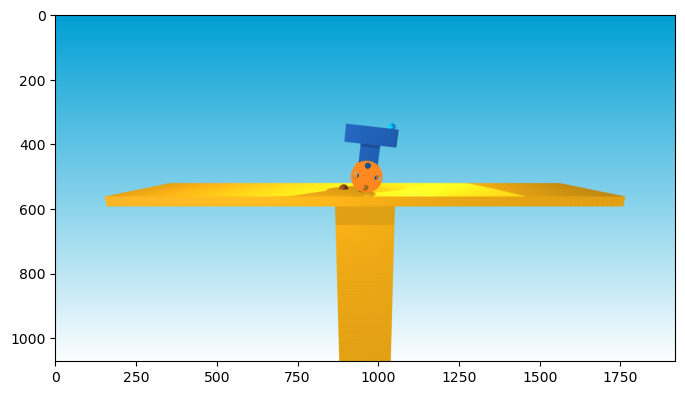

In [1310]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot5.png', rgba)

Plot the results.

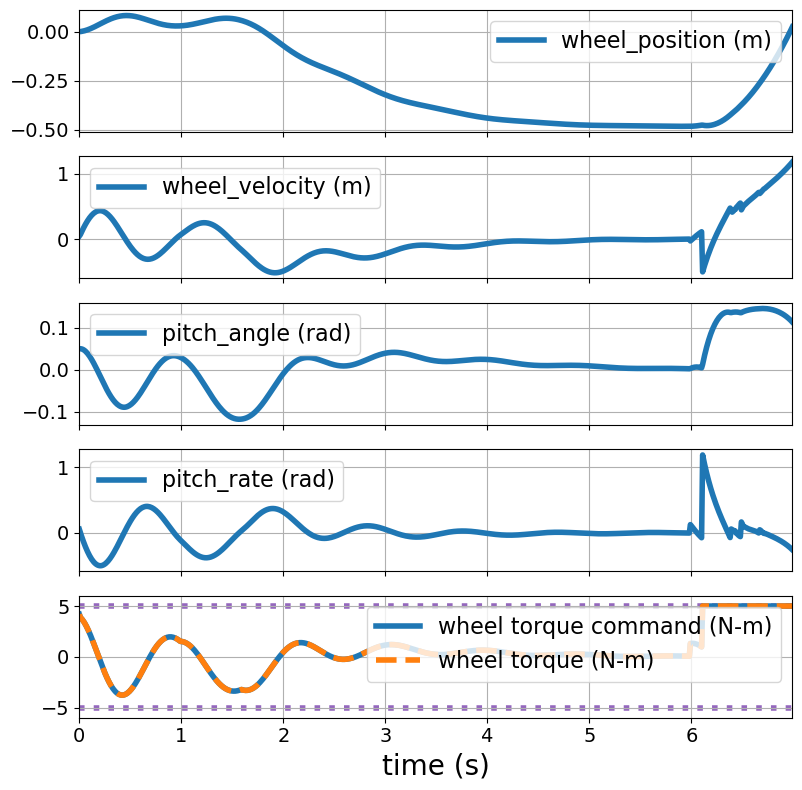

In [1311]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_wheel_position,
    ax_wheel_velocity,
    ax_pitch_angle,
    ax_pitch_rate,
    ax_wheel_torque,
) = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

# Plot wheel position
ax_wheel_position.plot(
    data['t'], data['wheel_position'],
    label='wheel_position (m)', linewidth=4,
)
ax_wheel_position.grid()
ax_wheel_position.legend(fontsize=16)
ax_wheel_position.tick_params(labelsize=14)

# Plot wheel velocity
ax_wheel_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel_velocity (m)', linewidth=4,
)
ax_wheel_velocity.grid()
ax_wheel_velocity.legend(fontsize=16)
ax_wheel_velocity.tick_params(labelsize=14)

# Plot pitch angle
ax_pitch_angle.plot(
    data['t'], data['pitch_angle'],
    label='pitch_angle (rad)', linewidth=4,
)
ax_pitch_angle.grid()
ax_pitch_angle.legend(fontsize=16)
ax_pitch_angle.tick_params(labelsize=14)

# Plot pitch rate
ax_pitch_rate.plot(
    data['t'], data['pitch_rate'],
    label='pitch_rate (rad)', linewidth=4,
)
ax_pitch_rate.grid()
ax_pitch_rate.legend(fontsize=16)
ax_pitch_rate.tick_params(labelsize=14)

# Plot wheel torque
ax_wheel_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.grid()
ax_wheel_torque.legend(fontsize=16)
ax_wheel_torque.tick_params(labelsize=14)
ax_wheel_torque.set_ylim(
    -1.2 * simulator.maximum_wheel_torque,
    1.2 * simulator.maximum_wheel_torque,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_wheel_torque.set_xlabel('time (s)', fontsize=20)
ax_wheel_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [1312]:
fig.savefig('my_figure5.png', facecolor='white', transparent=False)